In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [288]:
data = pd.read_csv('../artifacts/sentiment_analysis.csv')
data.head() , data.shape

(   id  label                                              tweet
 0   1      0  #fingerprint #Pregnancy Test https://goo.gl/h1...
 1   2      0  Finally a transparant silicon case ^^ Thanks t...
 2   3      0  We love this! Would you go? #talk #makememorie...
 3   4      0  I'm wired I know I'm George I was made that wa...
 4   5      1  What amazing service! Apple won't even talk to...,
 (7920, 3))

### preprocessing

In [289]:
data.duplicated().sum(), data.isnull().sum()

(0,
 id       0
 label    0
 tweet    0
 dtype: int64)

In [290]:
ps = PorterStemmer()
lem = WordNetLemmatizer()
def data_cleaning(text):
    review = re.sub('[^a-zA-Z]',' ' ,text)
    review = re.sub(r'https?:\/\/.*[\r\n]*',' ',review, flags=re.MULTILINE)
    review = review.lower()
    review = review.split()
    review = [lem.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = " ".join(review)
    return review

In [291]:
data['clean_tweets']=data['tweet'].apply(data_cleaning)

In [292]:
X = data['clean_tweets']
y = data['label']

In [293]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf.fit_transform(X).toarray()

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [308]:
y_train.value_counts().values,y_train.value_counts().index


(array([4114, 1430], dtype=int64), Index([0, 1], dtype='int64', name='label'))

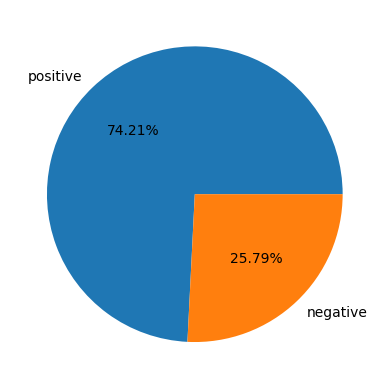

In [312]:
plt.pie(x=y_train.value_counts().values, labels=['positive' if i==0 else 'negative' for i in y_train.value_counts().index], autopct='%1.2f%%')
plt.show()

In [314]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

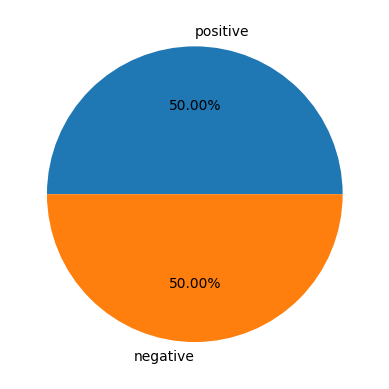

In [315]:
plt.pie(x=y_train_smote.value_counts().values, labels=['positive' if i==0 else 'negative' for i in y_train_smote.value_counts().index], autopct='%1.2f%%')
plt.show()

In [329]:
def model_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    pr = precision_score(y_pred, y_test)
    rec = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    print(f"accuracy: {acc}\nprecision: {pr}\nrecall: {rec}\nf1-score: {f1}")

In [341]:
params_nb = {
    'alpha': 0.89,
    'fit_prior': False,
}

model_nb = MultinomialNB(**params_nb)


model_nb.fit(X_train_smote,y_train_smote)

MultinomialNB(alpha=0.89, fit_prior=False)

In [342]:
model_predictions(model_nb, X_test, y_test)

accuracy: 0.8897306397306397
precision: 0.9429530201342282
recall: 0.7113924050632912
f1-score: 0.810966810966811


In [343]:
lgb_params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'learning_rate': 0.01,
    'num_leaves': 60,
    'random_state':42,
    'objective':'binary',
    'boosting_type': 'gbdt',
    'feature_fraction':0.9,
    'metric': 'binary_logloss',
    'sub_sample': 0.8,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5
}
model_lgb = lgb.LGBMClassifier(**lgb_params)

model_lgb.fit(X_train_smote, y_train_smote)

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Number of positive: 4114, number of negative: 4114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

LGBMClassifier(feature_fraction=0.9, lambda_l1=0.5, lambda_l2=0.5,
               learning_rate=0.01, max_depth=10, metric='binary_logloss',
               n_estimators=1000, num_leaves=60, objective='binary',
               random_state=42, sub_sample=0.8)

In [344]:
model_predictions(model_lgb, X_test, y_test)

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
accuracy: 0.8872053872053872
precision: 0.8741610738255033
recall: 0.7296918767507002
f1-score: 0.7954198473282442


In [345]:
model_lr = LogisticRegression()
model_lr.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [346]:
model_predictions(model_lr, X_test, y_test)

accuracy: 0.9006734006734006
precision: 0.8959731543624161
recall: 0.7542372881355932
f1-score: 0.8190184049079755


In [337]:
model_svm = SVC(random_state=0)
model_svm.fit(X_train_smote , y_train_smote)

SVC(random_state=0)

In [340]:
model_predictions(model_svm, X_test, y_test)

accuracy: 0.8994107744107744
precision: 0.8355704697986577
recall: 0.7793427230046949
f1-score: 0.8064777327935223


In [348]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [349]:
model_predictions(model_rf, X_test, y_test)

accuracy: 0.8893097643097643
precision: 0.87751677852349
recall: 0.7335203366058906
f1-score: 0.799083269671505


In [350]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [351]:
model_predictions(model_dt, X_test, y_test)

accuracy: 0.8316498316498316
precision: 0.6543624161073825
recall: 0.6678082191780822
f1-score: 0.6610169491525424


In [353]:
import pickle

with open('../static/model/model.pickel', 'wb') as file:
    pickle.dump(model_lr, file)